# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [3]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

### 1.Set your project path where you have your data and related files for this lab.

In [2]:
project_path = ''

### 2. Set the necessary parameters

## Setup

In [3]:
IMAGE_WIDTH = 128   
IMAGE_HEIGHT = 128     
path_train = project_path + 'train/'  

In [4]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [6]:
!mkdir train

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [7]:
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
    zf.extractall('train/')

In [8]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [5]:
images = os.listdir('train/images')
masks = os.listdir('train/masks')

masklist = []
imagelist = []
for filename in images:
    imagelist.append(filename)
for filename in masks:
    masklist.append(filename)

In [6]:
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

fff987cdb3.png
fff987cdb3.png
0108518d1e.png
0108518d1e.png


In [7]:
imagelist.sort()
masklist.sort()

# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [8]:
import cv2
import matplotlib.pyplot as plt

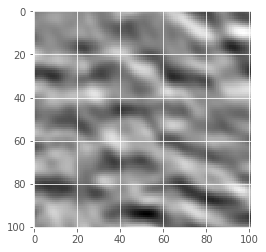

In [17]:
plt.imshow(cv2.imread('train/images/'+imagelist[0]))

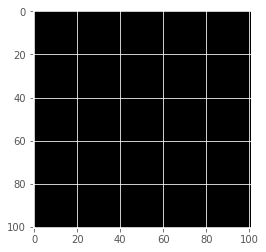

In [18]:
plt.imshow(cv2.imread('train/masks/'+imagelist[0]))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [9]:
from PIL import Image

In [26]:
def get_data():
    X = np.zeros((len(imagelist), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    y = np.zeros((len(masklist), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    
    for filename in imagelist:
        k = imagelist.index(filename)
        image_path = os.path.join('train/images', filename)
        mask_path = os.path.join('train/masks', filename)
        img = Image.open(image_path)
        img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        img = np.reshape(img.convert('L'), (128,128,1))
        X[k] = img
        mask = Image.open(mask_path)
        mask = mask.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        mask = np.reshape(mask.convert('L'), (128,128,1))
        y[k] = mask
        
    print('Done!')
    return X, y

X, y = get_data()

Done!


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

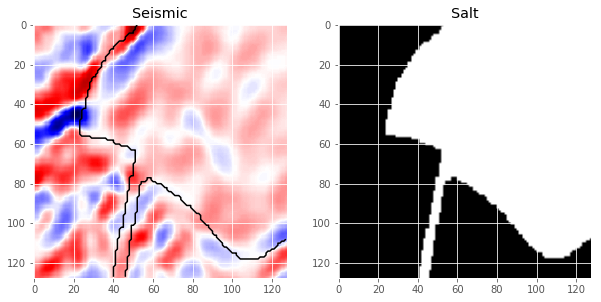

In [37]:
import random 
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### 8. Define loss and dice_coeff function.

In [28]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [29]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [30]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [31]:
X_train.shape

(3400, 128, 128, 1)

In [32]:
X_valid.shape

(600, 128, 128, 1)

In [33]:
y_train.shape

(3400, 128, 128, 1)

In [34]:
y_valid.shape

(600, 128, 128, 1)

In [35]:
N = X_train.shape[-1]
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 134, 134, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   3136        zero_padding2d_35[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

stage3_unit1_bn2 (BatchNormaliz (None, 8, 8, 256)    1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 8, 8, 256)    0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_52 (ZeroPadding2 (None, 10, 10, 256)  0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 8, 8, 256)    589824      zero_padding2d_52[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 8, 8, 256)    32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_24 (Ad

add_32 (Add)                    (None, 4, 4, 512)    0           stage4_unit3_conv2[0][0]         
                                                                 add_31[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 4, 4, 512)    2048        add_32[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 4, 4, 512)    0           bn1[0][0]                        
__________________________________________________________________________________________________
decoder_stage0_upsample (UpSamp (None, 8, 8, 512)    0           relu1[0][0]                      
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 8, 8, 768)    0           decoder_stage0_upsample[0][0]    
          

In [37]:
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

model.compile(optimizer='adam', loss=loss, metrics=[dice_coefficient])

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [38]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,    
    epochs=1,
    validation_data=(X_valid, y_valid)
)

Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - ETA: 55:23 - loss: -25.0697 - dice_coefficient: 1.201 - ETA: 46:05 - loss: -40.2858 - dice_coefficient: 1.276 - ETA: 42:11 - loss: -51.0506 - dice_coefficient: 1.327 - ETA: 40:14 - loss: -71.1904 - dice_coefficient: 1.396 - ETA: 38:41 - loss: -79.8239 - dice_coefficient: 1.421 - ETA: 37:10 - loss: -90.9111 - dice_coefficient: 1.433 - ETA: 35:51 - loss: -104.2138 - dice_coefficient: 1.44 - ETA: 34:45 - loss: -113.1659 - dice_coefficient: 1.44 - ETA: 33:46 - loss: -124.4677 - dice_coefficient: 1.45 - ETA: 32:51 - loss: -139.0148 - dice_coefficient: 1.47 - ETA: 31:55 - loss: -146.4957 - dice_coefficient: 1.48 - ETA: 31:01 - loss: -159.0377 - dice_coefficient: 1.50 - ETA: 30:10 - loss: -164.2542 - dice_coefficient: 1.51 - ETA: 29:21 - loss: -173.7134 - dice_coefficient: 1.52 - ETA: 28:32 - loss: -180.0236 - dice_coefficient: 1.53 - ETA: 27:43 - loss: -188.7215 - dice_coefficient: 1.54 - ET

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [39]:
model.evaluate(X_valid, y_valid, verbose=1)
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - ETA: 56 - ETA: 53 - ETA: 50 - ETA: 47 - ETA: 44 - ETA: 41 - ETA: 37 - ETA: 34 - ETA: 31 - ETA: 28 - ETA: 25 - ETA: 21 - ETA: 18 - ETA: 15 - ETA: 12 - ETA: 8 - ETA:  - ETA:  - 61s 101ms/step


In [40]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [41]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

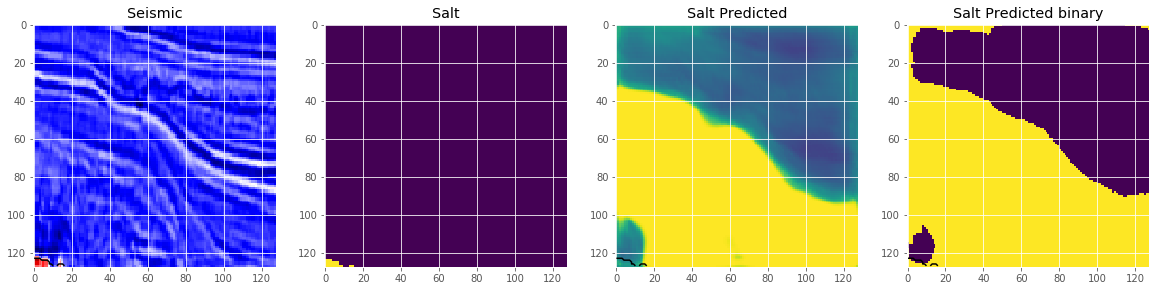

In [42]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
#

### Import Keras and other libraries

In [1]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

Using TensorFlow backend.


## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [8]:
txtfilelist = glob.glob("data/*.txt")

In [10]:
txtfilelist

['data\\Selected prose of oscar wilde with a Preface by Robert Ross.txt',
 'data\\Shorter Prose Pieces.txt',
 'data\\The Ballad of Reading Gaol.txt',
 'data\\The Canterville Ghost.txt',
 'data\\The Duchess of Padua.txt',
 'data\\The Happy Prince and other tales.txt',
 'data\\The Importance of Being Earnest.txt',
 'data\\The Picture of Dorian Gray.txt',
 'data\\The Soul of Man.txt',
 'data\\Vera or, The Nihilists.txt']

### Read the data

Read contents of every file from the list and append the text in a new list

In [13]:
text = []
for filename in txtfilelist:
    filetext = open(filename, encoding="utf8")
    text.append(filetext.read())
    filetext.close()

## Process the text
Initialize and fit the tokenizer

In [15]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(text)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [16]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [17]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [18]:
sequences = tokenizer.texts_to_sequences(text)

### Generate Features and Labels

In [19]:
features = []
labels = []

training_length = 50
for seq in sequences:
    for i in range(training_length, training_length+300):
        extract = seq[i - training_length: i - training_length + 20]

        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [20]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

X_train, X_valid = np.array(train_features), np.array(valid_features)
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [21]:
for i, sequence in enumerate(X_train[:2]):
    text = []
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: governess the scenes of the play act i algernon moncrieff's flat in half moon street w act ii the

Label: garden

Features: room lane is arranging afternoon tea on the table and after the music has ceased algernon enters algernon did

Label: you



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [22]:
model = Sequential()

model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_words, activation='softmax'))

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1478800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14788)             961220    
Total params: 2,486,420
Trainable params: 2,486,420
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [24]:
h = model.fit(X_train, y_train, epochs = 100, batch_size = 50, 
          verbose = 1)

Epoch 1/100
2100/2100 [==============================] - ETA: 4s - loss: 4.7213 - acc: 0.180 - ETA: 4s - loss: 5.0104 - acc: 0.130 - ETA: 4s - loss: 5.0170 - acc: 0.126 - ETA: 4s - loss: 4.9209 - acc: 0.115 - ETA: 4s - loss: 4.8953 - acc: 0.116 - ETA: 4s - loss: 4.8858 - acc: 0.110 - ETA: 4s - loss: 4.9306 - acc: 0.097 - ETA: 4s - loss: 4.9562 - acc: 0.100 - ETA: 3s - loss: 4.9384 - acc: 0.095 - ETA: 3s - loss: 4.9394 - acc: 0.094 - ETA: 3s - loss: 4.8961 - acc: 0.094 - ETA: 3s - loss: 4.9635 - acc: 0.090 - ETA: 3s - loss: 4.9538 - acc: 0.090 - ETA: 3s - loss: 4.9164 - acc: 0.092 - ETA: 3s - loss: 4.9320 - acc: 0.093 - ETA: 3s - loss: 4.9547 - acc: 0.093 - ETA: 2s - loss: 4.9608 - acc: 0.091 - ETA: 2s - loss: 4.9633 - acc: 0.092 - ETA: 2s - loss: 4.9730 - acc: 0.090 - ETA: 2s - loss: 4.9475 - acc: 0.093 - ETA: 2s - loss: 4.9282 - acc: 0.093 - ETA: 2s - loss: 4.9246 - acc: 0.094 - ETA: 2s - loss: 4.9356 - acc: 0.093 - ETA: 2s - loss: 4.9379 - acc: 0.091 - ETA: 2s - loss: 4.9277 - acc: 0

2100/2100 [==============================] - ETA: 4s - loss: 4.5001 - acc: 0.120 - ETA: 4s - loss: 4.4800 - acc: 0.110 - ETA: 4s - loss: 4.4966 - acc: 0.106 - ETA: 4s - loss: 4.4631 - acc: 0.125 - ETA: 4s - loss: 4.4869 - acc: 0.116 - ETA: 4s - loss: 4.4237 - acc: 0.126 - ETA: 4s - loss: 4.3966 - acc: 0.128 - ETA: 4s - loss: 4.4386 - acc: 0.125 - ETA: 3s - loss: 4.4469 - acc: 0.131 - ETA: 3s - loss: 4.4419 - acc: 0.134 - ETA: 3s - loss: 4.4202 - acc: 0.138 - ETA: 3s - loss: 4.4009 - acc: 0.135 - ETA: 3s - loss: 4.4060 - acc: 0.132 - ETA: 3s - loss: 4.4258 - acc: 0.132 - ETA: 3s - loss: 4.4410 - acc: 0.132 - ETA: 3s - loss: 4.4187 - acc: 0.135 - ETA: 2s - loss: 4.4494 - acc: 0.132 - ETA: 2s - loss: 4.4458 - acc: 0.133 - ETA: 2s - loss: 4.4720 - acc: 0.131 - ETA: 2s - loss: 4.4801 - acc: 0.126 - ETA: 2s - loss: 4.4911 - acc: 0.125 - ETA: 2s - loss: 4.5067 - acc: 0.123 - ETA: 2s - loss: 4.5115 - acc: 0.124 - ETA: 2s - loss: 4.5180 - acc: 0.125 - ETA: 2s - loss: 4.5111 - acc: 0.128 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 4.3826 - acc: 0.120 - ETA: 4s - loss: 3.8605 - acc: 0.200 - ETA: 4s - loss: 3.8434 - acc: 0.220 - ETA: 4s - loss: 3.8447 - acc: 0.225 - ETA: 4s - loss: 3.8769 - acc: 0.224 - ETA: 4s - loss: 3.9326 - acc: 0.216 - ETA: 4s - loss: 3.9156 - acc: 0.217 - ETA: 4s - loss: 3.9265 - acc: 0.212 - ETA: 3s - loss: 3.9453 - acc: 0.215 - ETA: 3s - loss: 3.9711 - acc: 0.214 - ETA: 3s - loss: 3.9606 - acc: 0.209 - ETA: 3s - loss: 3.9741 - acc: 0.203 - ETA: 3s - loss: 3.9759 - acc: 0.200 - ETA: 3s - loss: 3.9931 - acc: 0.194 - ETA: 3s - loss: 3.9963 - acc: 0.196 - ETA: 3s - loss: 3.9547 - acc: 0.202 - ETA: 2s - loss: 3.9565 - acc: 0.203 - ETA: 2s - loss: 3.9603 - acc: 0.205 - ETA: 2s - loss: 3.9667 - acc: 0.204 - ETA: 2s - loss: 3.9612 - acc: 0.206 - ETA: 2s - loss: 3.9862 - acc: 0.204 - ETA: 2s - loss: 3.9900 - acc: 0.205 - ETA: 2s - loss: 3.9957 - acc: 0.202 - ETA: 2s - loss: 3.9954 - acc: 0.202 - ETA: 1s - loss: 3.9780 - acc: 0.204 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 3.4407 - acc: 0.260 - ETA: 4s - loss: 3.4539 - acc: 0.220 - ETA: 4s - loss: 3.3027 - acc: 0.266 - ETA: 4s - loss: 3.3505 - acc: 0.270 - ETA: 4s - loss: 3.4185 - acc: 0.264 - ETA: 4s - loss: 3.4509 - acc: 0.253 - ETA: 3s - loss: 3.4053 - acc: 0.260 - ETA: 3s - loss: 3.3828 - acc: 0.265 - ETA: 3s - loss: 3.4078 - acc: 0.260 - ETA: 3s - loss: 3.4267 - acc: 0.256 - ETA: 3s - loss: 3.4277 - acc: 0.254 - ETA: 3s - loss: 3.4211 - acc: 0.253 - ETA: 3s - loss: 3.4304 - acc: 0.249 - ETA: 3s - loss: 3.4272 - acc: 0.247 - ETA: 3s - loss: 3.4274 - acc: 0.246 - ETA: 3s - loss: 3.4339 - acc: 0.245 - ETA: 2s - loss: 3.4472 - acc: 0.245 - ETA: 2s - loss: 3.4717 - acc: 0.242 - ETA: 2s - loss: 3.4579 - acc: 0.245 - ETA: 2s - loss: 3.4594 - acc: 0.244 - ETA: 2s - loss: 3.4638 - acc: 0.242 - ETA: 2s - loss: 3.4599 - acc: 0.245 - ETA: 2s - loss: 3.4552 - acc: 0.247 - ETA: 2s - loss: 3.4607 - acc: 0.243 - ETA: 1s - loss: 3.4413 - acc: 0.247 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 2.6593 - acc: 0.360 - ETA: 4s - loss: 2.8455 - acc: 0.290 - ETA: 4s - loss: 2.9179 - acc: 0.273 - ETA: 4s - loss: 2.9350 - acc: 0.275 - ETA: 4s - loss: 2.8682 - acc: 0.292 - ETA: 4s - loss: 2.8608 - acc: 0.303 - ETA: 4s - loss: 2.8429 - acc: 0.322 - ETA: 3s - loss: 2.8431 - acc: 0.330 - ETA: 3s - loss: 2.8565 - acc: 0.324 - ETA: 3s - loss: 2.8607 - acc: 0.328 - ETA: 3s - loss: 2.8188 - acc: 0.334 - ETA: 3s - loss: 2.8383 - acc: 0.333 - ETA: 3s - loss: 2.8073 - acc: 0.343 - ETA: 3s - loss: 2.8251 - acc: 0.335 - ETA: 3s - loss: 2.8331 - acc: 0.333 - ETA: 3s - loss: 2.8393 - acc: 0.333 - ETA: 2s - loss: 2.8361 - acc: 0.337 - ETA: 2s - loss: 2.8465 - acc: 0.330 - ETA: 2s - loss: 2.8490 - acc: 0.329 - ETA: 2s - loss: 2.8474 - acc: 0.327 - ETA: 2s - loss: 2.8353 - acc: 0.328 - ETA: 2s - loss: 2.8279 - acc: 0.330 - ETA: 2s - loss: 2.8107 - acc: 0.334 - ETA: 2s - loss: 2.8173 - acc: 0.333 - ETA: 1s - loss: 2.8274 - acc: 0.333 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 2.0959 - acc: 0.420 - ETA: 4s - loss: 2.0963 - acc: 0.420 - ETA: 4s - loss: 2.2655 - acc: 0.406 - ETA: 4s - loss: 2.2511 - acc: 0.415 - ETA: 4s - loss: 2.3068 - acc: 0.400 - ETA: 4s - loss: 2.3400 - acc: 0.393 - ETA: 4s - loss: 2.4196 - acc: 0.388 - ETA: 3s - loss: 2.4488 - acc: 0.382 - ETA: 3s - loss: 2.5048 - acc: 0.382 - ETA: 3s - loss: 2.4755 - acc: 0.388 - ETA: 3s - loss: 2.4831 - acc: 0.376 - ETA: 3s - loss: 2.4558 - acc: 0.383 - ETA: 3s - loss: 2.4498 - acc: 0.389 - ETA: 3s - loss: 2.4300 - acc: 0.395 - ETA: 3s - loss: 2.4085 - acc: 0.396 - ETA: 3s - loss: 2.4212 - acc: 0.397 - ETA: 2s - loss: 2.4267 - acc: 0.400 - ETA: 2s - loss: 2.4269 - acc: 0.395 - ETA: 2s - loss: 2.4269 - acc: 0.396 - ETA: 2s - loss: 2.4165 - acc: 0.401 - ETA: 2s - loss: 2.4245 - acc: 0.400 - ETA: 2s - loss: 2.4400 - acc: 0.396 - ETA: 2s - loss: 2.4353 - acc: 0.399 - ETA: 2s - loss: 2.4331 - acc: 0.396 - ETA: 1s - loss: 2.4326 - acc: 0.396 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 2.0802 - acc: 0.540 - ETA: 4s - loss: 2.1057 - acc: 0.490 - ETA: 4s - loss: 2.1696 - acc: 0.473 - ETA: 4s - loss: 2.0413 - acc: 0.490 - ETA: 4s - loss: 2.0646 - acc: 0.480 - ETA: 4s - loss: 2.0580 - acc: 0.470 - ETA: 4s - loss: 2.0493 - acc: 0.465 - ETA: 3s - loss: 2.0178 - acc: 0.482 - ETA: 3s - loss: 2.0621 - acc: 0.475 - ETA: 3s - loss: 2.0549 - acc: 0.476 - ETA: 3s - loss: 2.0639 - acc: 0.469 - ETA: 3s - loss: 2.0796 - acc: 0.463 - ETA: 3s - loss: 2.0903 - acc: 0.460 - ETA: 3s - loss: 2.1207 - acc: 0.457 - ETA: 3s - loss: 2.1251 - acc: 0.456 - ETA: 3s - loss: 2.1326 - acc: 0.452 - ETA: 2s - loss: 2.1492 - acc: 0.451 - ETA: 2s - loss: 2.1654 - acc: 0.445 - ETA: 2s - loss: 2.1594 - acc: 0.443 - ETA: 2s - loss: 2.1565 - acc: 0.441 - ETA: 2s - loss: 2.1640 - acc: 0.438 - ETA: 2s - loss: 2.1507 - acc: 0.439 - ETA: 2s - loss: 2.1418 - acc: 0.442 - ETA: 2s - loss: 2.1374 - acc: 0.443 - ETA: 1s - loss: 2.1314 - acc: 0.442 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 1.9961 - acc: 0.540 - ETA: 4s - loss: 1.9910 - acc: 0.520 - ETA: 4s - loss: 1.8899 - acc: 0.520 - ETA: 4s - loss: 1.8078 - acc: 0.545 - ETA: 4s - loss: 1.7802 - acc: 0.556 - ETA: 4s - loss: 1.7979 - acc: 0.553 - ETA: 4s - loss: 1.7415 - acc: 0.560 - ETA: 3s - loss: 1.7383 - acc: 0.555 - ETA: 3s - loss: 1.7231 - acc: 0.546 - ETA: 3s - loss: 1.7470 - acc: 0.546 - ETA: 3s - loss: 1.7668 - acc: 0.541 - ETA: 3s - loss: 1.7474 - acc: 0.551 - ETA: 3s - loss: 1.7392 - acc: 0.547 - ETA: 3s - loss: 1.7435 - acc: 0.541 - ETA: 3s - loss: 1.7164 - acc: 0.552 - ETA: 3s - loss: 1.7319 - acc: 0.546 - ETA: 2s - loss: 1.7266 - acc: 0.545 - ETA: 2s - loss: 1.7416 - acc: 0.540 - ETA: 2s - loss: 1.7410 - acc: 0.538 - ETA: 2s - loss: 1.7541 - acc: 0.542 - ETA: 2s - loss: 1.7528 - acc: 0.543 - ETA: 2s - loss: 1.7717 - acc: 0.539 - ETA: 2s - loss: 1.7936 - acc: 0.533 - ETA: 2s - loss: 1.7889 - acc: 0.533 - ETA: 1s - loss: 1.7781 - acc: 0.536 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 1.5300 - acc: 0.560 - ETA: 4s - loss: 1.7015 - acc: 0.510 - ETA: 4s - loss: 1.6279 - acc: 0.540 - ETA: 4s - loss: 1.5618 - acc: 0.575 - ETA: 4s - loss: 1.5220 - acc: 0.588 - ETA: 4s - loss: 1.5639 - acc: 0.576 - ETA: 4s - loss: 1.5885 - acc: 0.580 - ETA: 4s - loss: 1.5819 - acc: 0.585 - ETA: 3s - loss: 1.5486 - acc: 0.588 - ETA: 3s - loss: 1.5698 - acc: 0.588 - ETA: 3s - loss: 1.5562 - acc: 0.589 - ETA: 3s - loss: 1.5567 - acc: 0.585 - ETA: 3s - loss: 1.5787 - acc: 0.580 - ETA: 3s - loss: 1.5860 - acc: 0.577 - ETA: 3s - loss: 1.5818 - acc: 0.580 - ETA: 3s - loss: 1.5930 - acc: 0.572 - ETA: 3s - loss: 1.5856 - acc: 0.575 - ETA: 2s - loss: 1.5862 - acc: 0.574 - ETA: 2s - loss: 1.5806 - acc: 0.575 - ETA: 2s - loss: 1.5651 - acc: 0.579 - ETA: 2s - loss: 1.5450 - acc: 0.583 - ETA: 2s - loss: 1.5593 - acc: 0.578 - ETA: 2s - loss: 1.5578 - acc: 0.579 - ETA: 2s - loss: 1.5683 - acc: 0.579 - ETA: 2s - loss: 1.5671 - acc: 0.579 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.9573 - acc: 0.780 - ETA: 4s - loss: 1.2123 - acc: 0.690 - ETA: 4s - loss: 1.2376 - acc: 0.693 - ETA: 4s - loss: 1.3422 - acc: 0.680 - ETA: 4s - loss: 1.3443 - acc: 0.672 - ETA: 3s - loss: 1.3475 - acc: 0.663 - ETA: 3s - loss: 1.3312 - acc: 0.660 - ETA: 3s - loss: 1.3423 - acc: 0.665 - ETA: 3s - loss: 1.3275 - acc: 0.671 - ETA: 3s - loss: 1.3401 - acc: 0.664 - ETA: 3s - loss: 1.3647 - acc: 0.656 - ETA: 3s - loss: 1.3738 - acc: 0.655 - ETA: 3s - loss: 1.3714 - acc: 0.652 - ETA: 3s - loss: 1.3837 - acc: 0.647 - ETA: 3s - loss: 1.3894 - acc: 0.646 - ETA: 3s - loss: 1.4255 - acc: 0.636 - ETA: 2s - loss: 1.4147 - acc: 0.640 - ETA: 2s - loss: 1.4235 - acc: 0.633 - ETA: 2s - loss: 1.4248 - acc: 0.632 - ETA: 2s - loss: 1.4173 - acc: 0.635 - ETA: 2s - loss: 1.4120 - acc: 0.636 - ETA: 2s - loss: 1.4367 - acc: 0.629 - ETA: 2s - loss: 1.4419 - acc: 0.628 - ETA: 2s - loss: 1.4467 - acc: 0.628 - ETA: 1s - loss: 1.4410 - acc: 0.628 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 1.4156 - acc: 0.640 - ETA: 4s - loss: 1.2665 - acc: 0.710 - ETA: 4s - loss: 1.2899 - acc: 0.666 - ETA: 4s - loss: 1.2751 - acc: 0.665 - ETA: 4s - loss: 1.2812 - acc: 0.656 - ETA: 3s - loss: 1.2635 - acc: 0.656 - ETA: 3s - loss: 1.2679 - acc: 0.654 - ETA: 3s - loss: 1.2809 - acc: 0.647 - ETA: 3s - loss: 1.2854 - acc: 0.646 - ETA: 3s - loss: 1.2623 - acc: 0.648 - ETA: 3s - loss: 1.2725 - acc: 0.641 - ETA: 3s - loss: 1.2864 - acc: 0.636 - ETA: 3s - loss: 1.2647 - acc: 0.641 - ETA: 3s - loss: 1.2473 - acc: 0.647 - ETA: 3s - loss: 1.2366 - acc: 0.648 - ETA: 2s - loss: 1.2293 - acc: 0.651 - ETA: 2s - loss: 1.2354 - acc: 0.647 - ETA: 2s - loss: 1.2286 - acc: 0.650 - ETA: 2s - loss: 1.2318 - acc: 0.649 - ETA: 2s - loss: 1.2430 - acc: 0.649 - ETA: 2s - loss: 1.2397 - acc: 0.652 - ETA: 2s - loss: 1.2489 - acc: 0.650 - ETA: 2s - loss: 1.2348 - acc: 0.655 - ETA: 2s - loss: 1.2511 - acc: 0.650 - ETA: 1s - loss: 1.2603 - acc: 0.646 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 1.4536 - acc: 0.560 - ETA: 4s - loss: 1.3277 - acc: 0.640 - ETA: 4s - loss: 1.3519 - acc: 0.626 - ETA: 4s - loss: 1.2896 - acc: 0.635 - ETA: 4s - loss: 1.2347 - acc: 0.652 - ETA: 4s - loss: 1.2433 - acc: 0.643 - ETA: 4s - loss: 1.2506 - acc: 0.642 - ETA: 4s - loss: 1.2024 - acc: 0.660 - ETA: 4s - loss: 1.2107 - acc: 0.653 - ETA: 4s - loss: 1.2156 - acc: 0.640 - ETA: 4s - loss: 1.2073 - acc: 0.643 - ETA: 4s - loss: 1.1885 - acc: 0.651 - ETA: 3s - loss: 1.1801 - acc: 0.655 - ETA: 3s - loss: 1.1813 - acc: 0.651 - ETA: 3s - loss: 1.1599 - acc: 0.661 - ETA: 3s - loss: 1.1628 - acc: 0.667 - ETA: 3s - loss: 1.1733 - acc: 0.664 - ETA: 3s - loss: 1.1706 - acc: 0.662 - ETA: 3s - loss: 1.1575 - acc: 0.667 - ETA: 2s - loss: 1.1552 - acc: 0.667 - ETA: 2s - loss: 1.1537 - acc: 0.662 - ETA: 2s - loss: 1.1454 - acc: 0.663 - ETA: 2s - loss: 1.1385 - acc: 0.667 - ETA: 2s - loss: 1.1323 - acc: 0.670 - ETA: 2s - loss: 1.1309 - acc: 0.672 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.8859 - acc: 0.800 - ETA: 4s - loss: 1.0161 - acc: 0.670 - ETA: 4s - loss: 0.9961 - acc: 0.673 - ETA: 4s - loss: 0.9612 - acc: 0.700 - ETA: 4s - loss: 0.9236 - acc: 0.724 - ETA: 4s - loss: 0.9081 - acc: 0.726 - ETA: 4s - loss: 0.9477 - acc: 0.705 - ETA: 4s - loss: 0.9549 - acc: 0.707 - ETA: 4s - loss: 0.9760 - acc: 0.706 - ETA: 3s - loss: 0.9925 - acc: 0.694 - ETA: 3s - loss: 0.9721 - acc: 0.698 - ETA: 3s - loss: 0.9932 - acc: 0.686 - ETA: 3s - loss: 0.9984 - acc: 0.680 - ETA: 3s - loss: 1.0125 - acc: 0.674 - ETA: 3s - loss: 0.9951 - acc: 0.682 - ETA: 3s - loss: 0.9843 - acc: 0.686 - ETA: 3s - loss: 0.9832 - acc: 0.689 - ETA: 2s - loss: 0.9726 - acc: 0.692 - ETA: 2s - loss: 0.9800 - acc: 0.690 - ETA: 2s - loss: 0.9787 - acc: 0.692 - ETA: 2s - loss: 0.9692 - acc: 0.696 - ETA: 2s - loss: 0.9730 - acc: 0.695 - ETA: 2s - loss: 0.9750 - acc: 0.693 - ETA: 2s - loss: 0.9670 - acc: 0.699 - ETA: 2s - loss: 0.9719 - acc: 0.696 - ETA: 

### Save Model

In [25]:
model.save('data/model_100epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [26]:
model = load_model('data/model_100epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [ ]:
model.fit(X_train, y_train, batch_size=50, epochs=100)

Epoch 1/100
2100/2100 [==============================] - ETA: 1:05 - loss: 0.8566 - acc: 0.780 - ETA: 34s - loss: 0.9211 - acc: 0.740 - ETA: 23s - loss: 0.8811 - acc: 0.76 - ETA: 18s - loss: 0.9066 - acc: 0.74 - ETA: 15s - loss: 0.9016 - acc: 0.74 - ETA: 13s - loss: 0.8896 - acc: 0.74 - ETA: 11s - loss: 0.8662 - acc: 0.74 - ETA: 10s - loss: 0.8854 - acc: 0.73 - ETA: 9s - loss: 0.9014 - acc: 0.7400 - ETA: 8s - loss: 0.9289 - acc: 0.736 - ETA: 7s - loss: 0.9137 - acc: 0.738 - ETA: 7s - loss: 0.9252 - acc: 0.733 - ETA: 6s - loss: 0.9127 - acc: 0.741 - ETA: 6s - loss: 0.9390 - acc: 0.732 - ETA: 5s - loss: 0.9351 - acc: 0.737 - ETA: 5s - loss: 0.9343 - acc: 0.736 - ETA: 5s - loss: 0.9575 - acc: 0.731 - ETA: 4s - loss: 0.9459 - acc: 0.735 - ETA: 4s - loss: 0.9447 - acc: 0.736 - ETA: 4s - loss: 0.9541 - acc: 0.733 - ETA: 4s - loss: 0.9457 - acc: 0.736 - ETA: 3s - loss: 0.9415 - acc: 0.739 - ETA: 3s - loss: 0.9484 - acc: 0.736 - ETA: 3s - loss: 0.9517 - acc: 0.737 - ETA: 3s - loss: 0.9594 - ac

2100/2100 [==============================] - ETA: 4s - loss: 0.6643 - acc: 0.760 - ETA: 4s - loss: 0.6688 - acc: 0.800 - ETA: 4s - loss: 0.7177 - acc: 0.800 - ETA: 4s - loss: 0.6986 - acc: 0.805 - ETA: 4s - loss: 0.6941 - acc: 0.800 - ETA: 4s - loss: 0.7318 - acc: 0.790 - ETA: 4s - loss: 0.7530 - acc: 0.780 - ETA: 3s - loss: 0.7490 - acc: 0.790 - ETA: 3s - loss: 0.7396 - acc: 0.788 - ETA: 3s - loss: 0.7645 - acc: 0.780 - ETA: 3s - loss: 0.7776 - acc: 0.769 - ETA: 3s - loss: 0.7851 - acc: 0.761 - ETA: 3s - loss: 0.7961 - acc: 0.761 - ETA: 3s - loss: 0.8135 - acc: 0.757 - ETA: 3s - loss: 0.8139 - acc: 0.753 - ETA: 2s - loss: 0.8102 - acc: 0.755 - ETA: 2s - loss: 0.8189 - acc: 0.750 - ETA: 2s - loss: 0.8269 - acc: 0.746 - ETA: 2s - loss: 0.8238 - acc: 0.746 - ETA: 2s - loss: 0.8271 - acc: 0.747 - ETA: 2s - loss: 0.8267 - acc: 0.746 - ETA: 2s - loss: 0.8252 - acc: 0.750 - ETA: 2s - loss: 0.8192 - acc: 0.748 - ETA: 2s - loss: 0.8224 - acc: 0.748 - ETA: 1s - loss: 0.8178 - acc: 0.751 - ETA: 

2100/2100 [==============================] - ETA: 5s - loss: 0.8055 - acc: 0.800 - ETA: 4s - loss: 0.9016 - acc: 0.720 - ETA: 4s - loss: 0.9286 - acc: 0.726 - ETA: 4s - loss: 0.8738 - acc: 0.745 - ETA: 4s - loss: 0.8409 - acc: 0.756 - ETA: 4s - loss: 0.8097 - acc: 0.770 - ETA: 4s - loss: 0.8292 - acc: 0.762 - ETA: 3s - loss: 0.8026 - acc: 0.772 - ETA: 3s - loss: 0.7980 - acc: 0.777 - ETA: 3s - loss: 0.8045 - acc: 0.770 - ETA: 3s - loss: 0.7968 - acc: 0.776 - ETA: 3s - loss: 0.8112 - acc: 0.773 - ETA: 3s - loss: 0.8190 - acc: 0.769 - ETA: 3s - loss: 0.8125 - acc: 0.764 - ETA: 3s - loss: 0.8093 - acc: 0.764 - ETA: 2s - loss: 0.7849 - acc: 0.776 - ETA: 2s - loss: 0.7979 - acc: 0.772 - ETA: 2s - loss: 0.8042 - acc: 0.771 - ETA: 2s - loss: 0.8038 - acc: 0.772 - ETA: 2s - loss: 0.8137 - acc: 0.768 - ETA: 2s - loss: 0.8187 - acc: 0.765 - ETA: 2s - loss: 0.8060 - acc: 0.767 - ETA: 2s - loss: 0.8046 - acc: 0.768 - ETA: 2s - loss: 0.8143 - acc: 0.766 - ETA: 1s - loss: 0.8170 - acc: 0.764 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.8563 - acc: 0.740 - ETA: 4s - loss: 0.7672 - acc: 0.790 - ETA: 4s - loss: 0.7459 - acc: 0.793 - ETA: 4s - loss: 0.7314 - acc: 0.800 - ETA: 4s - loss: 0.7754 - acc: 0.788 - ETA: 4s - loss: 0.7262 - acc: 0.800 - ETA: 4s - loss: 0.7057 - acc: 0.802 - ETA: 3s - loss: 0.7142 - acc: 0.800 - ETA: 3s - loss: 0.7045 - acc: 0.802 - ETA: 3s - loss: 0.7197 - acc: 0.796 - ETA: 3s - loss: 0.7129 - acc: 0.798 - ETA: 3s - loss: 0.6940 - acc: 0.805 - ETA: 3s - loss: 0.7065 - acc: 0.804 - ETA: 3s - loss: 0.7064 - acc: 0.805 - ETA: 3s - loss: 0.7252 - acc: 0.800 - ETA: 3s - loss: 0.7261 - acc: 0.801 - ETA: 2s - loss: 0.7504 - acc: 0.790 - ETA: 2s - loss: 0.7526 - acc: 0.791 - ETA: 2s - loss: 0.7385 - acc: 0.793 - ETA: 2s - loss: 0.7428 - acc: 0.794 - ETA: 2s - loss: 0.7411 - acc: 0.793 - ETA: 2s - loss: 0.7294 - acc: 0.795 - ETA: 2s - loss: 0.7303 - acc: 0.796 - ETA: 2s - loss: 0.7313 - acc: 0.796 - ETA: 1s - loss: 0.7299 - acc: 0.796 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.6267 - acc: 0.780 - ETA: 4s - loss: 0.6357 - acc: 0.780 - ETA: 4s - loss: 0.7051 - acc: 0.753 - ETA: 4s - loss: 0.7010 - acc: 0.780 - ETA: 4s - loss: 0.7450 - acc: 0.776 - ETA: 4s - loss: 0.7492 - acc: 0.773 - ETA: 4s - loss: 0.7183 - acc: 0.780 - ETA: 3s - loss: 0.7055 - acc: 0.782 - ETA: 3s - loss: 0.6894 - acc: 0.793 - ETA: 3s - loss: 0.7013 - acc: 0.798 - ETA: 3s - loss: 0.6816 - acc: 0.803 - ETA: 3s - loss: 0.6932 - acc: 0.801 - ETA: 3s - loss: 0.6875 - acc: 0.803 - ETA: 3s - loss: 0.7041 - acc: 0.800 - ETA: 3s - loss: 0.7179 - acc: 0.801 - ETA: 3s - loss: 0.7236 - acc: 0.802 - ETA: 2s - loss: 0.7378 - acc: 0.796 - ETA: 2s - loss: 0.7325 - acc: 0.796 - ETA: 2s - loss: 0.7322 - acc: 0.796 - ETA: 2s - loss: 0.7269 - acc: 0.801 - ETA: 2s - loss: 0.7277 - acc: 0.800 - ETA: 2s - loss: 0.7266 - acc: 0.800 - ETA: 2s - loss: 0.7163 - acc: 0.804 - ETA: 2s - loss: 0.7181 - acc: 0.804 - ETA: 2s - loss: 0.7128 - acc: 0.805 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.4762 - acc: 0.860 - ETA: 4s - loss: 0.6521 - acc: 0.790 - ETA: 4s - loss: 0.6915 - acc: 0.766 - ETA: 4s - loss: 0.6413 - acc: 0.780 - ETA: 4s - loss: 0.6098 - acc: 0.792 - ETA: 4s - loss: 0.5911 - acc: 0.803 - ETA: 3s - loss: 0.6181 - acc: 0.802 - ETA: 3s - loss: 0.6025 - acc: 0.810 - ETA: 3s - loss: 0.6136 - acc: 0.804 - ETA: 3s - loss: 0.6066 - acc: 0.812 - ETA: 3s - loss: 0.6071 - acc: 0.812 - ETA: 3s - loss: 0.6227 - acc: 0.808 - ETA: 3s - loss: 0.6217 - acc: 0.812 - ETA: 3s - loss: 0.6337 - acc: 0.811 - ETA: 3s - loss: 0.6269 - acc: 0.813 - ETA: 3s - loss: 0.6399 - acc: 0.808 - ETA: 2s - loss: 0.6371 - acc: 0.808 - ETA: 2s - loss: 0.6505 - acc: 0.805 - ETA: 2s - loss: 0.6583 - acc: 0.803 - ETA: 2s - loss: 0.6595 - acc: 0.804 - ETA: 2s - loss: 0.6421 - acc: 0.807 - ETA: 2s - loss: 0.6363 - acc: 0.810 - ETA: 2s - loss: 0.6389 - acc: 0.811 - ETA: 2s - loss: 0.6365 - acc: 0.809 - ETA: 1s - loss: 0.6396 - acc: 0.808 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.4454 - acc: 0.900 - ETA: 4s - loss: 0.5050 - acc: 0.860 - ETA: 4s - loss: 0.4991 - acc: 0.873 - ETA: 4s - loss: 0.5382 - acc: 0.855 - ETA: 4s - loss: 0.5340 - acc: 0.860 - ETA: 4s - loss: 0.5371 - acc: 0.846 - ETA: 4s - loss: 0.5851 - acc: 0.828 - ETA: 3s - loss: 0.5908 - acc: 0.830 - ETA: 3s - loss: 0.6184 - acc: 0.820 - ETA: 3s - loss: 0.6112 - acc: 0.820 - ETA: 3s - loss: 0.6290 - acc: 0.810 - ETA: 3s - loss: 0.5995 - acc: 0.820 - ETA: 3s - loss: 0.6129 - acc: 0.818 - ETA: 3s - loss: 0.6209 - acc: 0.812 - ETA: 3s - loss: 0.6139 - acc: 0.816 - ETA: 3s - loss: 0.6168 - acc: 0.816 - ETA: 2s - loss: 0.6139 - acc: 0.815 - ETA: 2s - loss: 0.6055 - acc: 0.816 - ETA: 2s - loss: 0.5989 - acc: 0.820 - ETA: 2s - loss: 0.6029 - acc: 0.819 - ETA: 2s - loss: 0.6111 - acc: 0.811 - ETA: 2s - loss: 0.6053 - acc: 0.813 - ETA: 2s - loss: 0.5970 - acc: 0.813 - ETA: 2s - loss: 0.6027 - acc: 0.813 - ETA: 1s - loss: 0.5964 - acc: 0.816 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.4288 - acc: 0.860 - ETA: 4s - loss: 0.5033 - acc: 0.850 - ETA: 4s - loss: 0.5612 - acc: 0.846 - ETA: 4s - loss: 0.6283 - acc: 0.835 - ETA: 4s - loss: 0.6392 - acc: 0.832 - ETA: 4s - loss: 0.6217 - acc: 0.833 - ETA: 3s - loss: 0.5985 - acc: 0.842 - ETA: 3s - loss: 0.5710 - acc: 0.852 - ETA: 3s - loss: 0.5614 - acc: 0.846 - ETA: 3s - loss: 0.5417 - acc: 0.854 - ETA: 3s - loss: 0.5246 - acc: 0.858 - ETA: 3s - loss: 0.5176 - acc: 0.856 - ETA: 3s - loss: 0.5355 - acc: 0.846 - ETA: 3s - loss: 0.5323 - acc: 0.847 - ETA: 3s - loss: 0.5309 - acc: 0.849 - ETA: 2s - loss: 0.5342 - acc: 0.850 - ETA: 2s - loss: 0.5425 - acc: 0.844 - ETA: 2s - loss: 0.5439 - acc: 0.846 - ETA: 2s - loss: 0.5458 - acc: 0.843 - ETA: 2s - loss: 0.5371 - acc: 0.846 - ETA: 2s - loss: 0.5326 - acc: 0.845 - ETA: 2s - loss: 0.5336 - acc: 0.850 - ETA: 2s - loss: 0.5379 - acc: 0.847 - ETA: 2s - loss: 0.5359 - acc: 0.848 - ETA: 1s - loss: 0.5462 - acc: 0.845 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.5538 - acc: 0.780 - ETA: 4s - loss: 0.4810 - acc: 0.820 - ETA: 4s - loss: 0.4609 - acc: 0.840 - ETA: 4s - loss: 0.4478 - acc: 0.845 - ETA: 4s - loss: 0.4910 - acc: 0.836 - ETA: 4s - loss: 0.5031 - acc: 0.836 - ETA: 4s - loss: 0.4903 - acc: 0.840 - ETA: 3s - loss: 0.5199 - acc: 0.825 - ETA: 3s - loss: 0.5241 - acc: 0.824 - ETA: 3s - loss: 0.5204 - acc: 0.828 - ETA: 3s - loss: 0.5107 - acc: 0.834 - ETA: 3s - loss: 0.5319 - acc: 0.828 - ETA: 3s - loss: 0.5459 - acc: 0.826 - ETA: 3s - loss: 0.5363 - acc: 0.828 - ETA: 3s - loss: 0.5328 - acc: 0.832 - ETA: 3s - loss: 0.5407 - acc: 0.832 - ETA: 2s - loss: 0.5302 - acc: 0.837 - ETA: 2s - loss: 0.5219 - acc: 0.842 - ETA: 2s - loss: 0.5186 - acc: 0.843 - ETA: 2s - loss: 0.5147 - acc: 0.846 - ETA: 2s - loss: 0.5075 - acc: 0.848 - ETA: 2s - loss: 0.5107 - acc: 0.845 - ETA: 2s - loss: 0.5003 - acc: 0.850 - ETA: 2s - loss: 0.5005 - acc: 0.848 - ETA: 1s - loss: 0.4972 - acc: 0.850 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.2814 - acc: 0.940 - ETA: 4s - loss: 0.3861 - acc: 0.900 - ETA: 4s - loss: 0.3889 - acc: 0.900 - ETA: 4s - loss: 0.4152 - acc: 0.890 - ETA: 4s - loss: 0.4283 - acc: 0.896 - ETA: 4s - loss: 0.4401 - acc: 0.893 - ETA: 3s - loss: 0.4820 - acc: 0.874 - ETA: 3s - loss: 0.4913 - acc: 0.870 - ETA: 3s - loss: 0.4868 - acc: 0.868 - ETA: 3s - loss: 0.4785 - acc: 0.866 - ETA: 3s - loss: 0.4760 - acc: 0.870 - ETA: 3s - loss: 0.4690 - acc: 0.875 - ETA: 3s - loss: 0.4711 - acc: 0.867 - ETA: 3s - loss: 0.4863 - acc: 0.858 - ETA: 3s - loss: 0.4870 - acc: 0.858 - ETA: 2s - loss: 0.4857 - acc: 0.860 - ETA: 2s - loss: 0.5007 - acc: 0.856 - ETA: 2s - loss: 0.4969 - acc: 0.856 - ETA: 2s - loss: 0.4922 - acc: 0.857 - ETA: 2s - loss: 0.4949 - acc: 0.857 - ETA: 2s - loss: 0.4967 - acc: 0.855 - ETA: 2s - loss: 0.4926 - acc: 0.855 - ETA: 2s - loss: 0.4855 - acc: 0.856 - ETA: 2s - loss: 0.4993 - acc: 0.852 - ETA: 1s - loss: 0.5034 - acc: 0.852 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.6199 - acc: 0.800 - ETA: 4s - loss: 0.6238 - acc: 0.790 - ETA: 4s - loss: 0.5195 - acc: 0.826 - ETA: 4s - loss: 0.5541 - acc: 0.815 - ETA: 4s - loss: 0.4841 - acc: 0.840 - ETA: 4s - loss: 0.5012 - acc: 0.833 - ETA: 3s - loss: 0.4830 - acc: 0.840 - ETA: 3s - loss: 0.4616 - acc: 0.847 - ETA: 3s - loss: 0.4589 - acc: 0.848 - ETA: 3s - loss: 0.4801 - acc: 0.846 - ETA: 3s - loss: 0.4950 - acc: 0.841 - ETA: 3s - loss: 0.4956 - acc: 0.841 - ETA: 3s - loss: 0.4993 - acc: 0.840 - ETA: 3s - loss: 0.4937 - acc: 0.840 - ETA: 3s - loss: 0.4904 - acc: 0.842 - ETA: 2s - loss: 0.4977 - acc: 0.838 - ETA: 2s - loss: 0.4952 - acc: 0.840 - ETA: 2s - loss: 0.4993 - acc: 0.840 - ETA: 2s - loss: 0.4969 - acc: 0.842 - ETA: 2s - loss: 0.5003 - acc: 0.840 - ETA: 2s - loss: 0.4985 - acc: 0.841 - ETA: 2s - loss: 0.4944 - acc: 0.842 - ETA: 2s - loss: 0.5022 - acc: 0.841 - ETA: 2s - loss: 0.5018 - acc: 0.840 - ETA: 1s - loss: 0.5123 - acc: 0.836 - ETA: 

2100/2100 [==============================] - ETA: 4s - loss: 0.7019 - acc: 0.780 - ETA: 4s - loss: 0.5278 - acc: 0.830 - ETA: 4s - loss: 0.5007 - acc: 0.846 - ETA: 4s - loss: 0.4912 - acc: 0.845 - ETA: 4s - loss: 0.4712 - acc: 0.856 - ETA: 4s - loss: 0.4361 - acc: 0.863 - ETA: 4s - loss: 0.4360 - acc: 0.857 - ETA: 4s - loss: 0.4383 - acc: 0.850 - ETA: 3s - loss: 0.4373 - acc: 0.848 - ETA: 3s - loss: 0.4278 - acc: 0.856 - ETA: 3s - loss: 0.4175 - acc: 0.865 - ETA: 3s - loss: 0.4162 - acc: 0.866 - ETA: 3s - loss: 0.4077 - acc: 0.872 - ETA: 3s - loss: 0.4011 - acc: 0.877 - ETA: 3s - loss: 0.4156 - acc: 0.870 - ETA: 3s - loss: 0.4088 - acc: 0.871 - ETA: 3s - loss: 0.4031 - acc: 0.872 - ETA: 3s - loss: 0.4144 - acc: 0.867 - ETA: 2s - loss: 0.4255 - acc: 0.862 - ETA: 2s - loss: 0.4337 - acc: 0.857 - ETA: 2s - loss: 0.4460 - acc: 0.852 - ETA: 2s - loss: 0.4456 - acc: 0.852 - ETA: 2s - loss: 0.4592 - acc: 0.849 - ETA: 2s - loss: 0.4587 - acc: 0.850 - ETA: 2s - loss: 0.4588 - acc: 0.852 - ETA: 

## Evaluation

In [0]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

## Generate text

In [0]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
